In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import plotly.plotly as py
from scipy.stats import norm
from bokeh.plotting import figure, show
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram

from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)

DATA_DIR = 'data'
GEN_DIR = os.path.join('data story', 'plots')
MIN_CONSIDER = 2000  # minimum number of datapoints to consider the data
MIN_CI = 10000  # minimum number of datapoints under which we assume the normal mean assumption holds

In [2]:
country_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_view.csv')).dropna()  # 3 rows have no mention_country
country_inner_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_view.csv'))
country_outer_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_view.csv'))
country_inner_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_type_view.csv'))
country_outer_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_type_view.csv'))
country_to_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_type_view.csv'))
media_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'media_to_country_view.csv.zip'))

# you won't find web scarping code for this dataframe because we manually parsed it 
# (multiline selections in sublime text <3 <3) because it was faster
r_w_b_2016 = pd.read_csv(os.path.join(DATA_DIR, 'R_W_B_2016.csv'))


In [3]:
country_codes = pd.read_csv(os.path.join(DATA_DIR, 'mapping_country_codes.csv')).drop(
    "Unnamed: 0", axis=1)  # needed for plotly
country_codes.columns = ["country_name", "country_ISO"]

In [4]:
# adapted from https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
def plot_dendrogram(model, title, save_fig, **kwargs):
    """
    =========================================
    Plot Hierarachical Clustering Dendrogram 
    =========================================
    This example plots the corresponding dendrogram of a hierarchical clustering
    using AgglomerativeClustering and the dendrogram method available in scipy.
    """

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    if save_fig:
        fig, ax = plt.subplots(figsize=(16, 10))
    else: 
        fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_title(title)
    dendrogram(linkage_matrix, orientation='right', **kwargs)
    if save_fig:
        plt.savefig(os.path.join(GEN_DIR, f"{title}.png"))

In [5]:
def add_CI_to_DF(df, mean_col_name="avg_tone", std_col_name="std_tone", count_col_name="count_mentions", std_mean_col_name=None, alpha=0.05):
    """
    by the Continuous limit theorem, the mean of a R.V. is distributed as N(\mu, \sigma^2/n)
    We will compute the bounds and add them to the dataframe assuming the CLT holds even tough 
    n is finite
    
    :param df: the dataframe
    :param mean_col_name: the name of the column of df containing the mean of the data
    :param std_col_name: the name of the column of df containing the std of the data
    :param count_col_name: the name of the column of df containing the count of the data
    :param std_mean_col_name: the std of the mean (if this is set, std_col_name and count_col_name are not used)
    :param alpha: the parameter alpha corresponding to the CI (ex: 0.05 for 95% CI)
    """

    interval = norm.interval(1-alpha)
    if std_mean_col_name is None:
        mean_std = df[std_col_name] / (df[count_col_name]**0.5)
    else:
        mean_std = df[std_mean_col_name]
    df[mean_col_name + "_low_CI"] = interval[0]*mean_std + df[mean_col_name]
    df[mean_col_name + "_high_CI"] = interval[1]*mean_std + df[mean_col_name]

In [6]:
# converts a matplotlib color scale to a plotly one
# https://plot.ly/python/matplotlib-colorscales/
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = (np.array(cmap(k*h)[:3])*255).astype(np.uint8)
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

In [7]:
def export_map_to_plotly(df, data_col_name, file_name, country_codes=country_codes, 
                     country_col_name="country"):
    """
    generates a plotly graph from the given dataframe
    
    :param df: the dataframe containing the data
    :param data_col_name: the name of the column containing the data
    :param file_name: name of the output plotly file
    :param country_codes: the df that contains the mapping from country names to country codes
    :param country_col_name: the name of the column of df that contains the country names
    """
    country_codes = country_codes[country_codes.count_mentions > MIN_CONSIDER]
    output = df.merge(country_codes, left_on=country_col_name, right_on="country_name",
                          suffixes=('',''))
    output["text"] = output.apply(lambda x: f"{x.country} <br>" + 
    (f"95% CI: [{x[data_col_name + '_low_CI'] :0.3f}, {x[data_col_name + '_high_CI']: 0.3f}] <br>"
    if x.count_mentions > MIN_CI else "") + f"{x.count_mentions: .0E} datapoints", axis=1)
    data = [ dict(
            type = 'choropleth',
            locations = output.country_ISO,
            z = np.round(output[data_col_name], 3),
            text = output.text,
            autocolorscale = True,
            reversescale = True,
            colorbar = dict(
                autotick = False,
                title = 'FILL IN'),
          ) ]

    layout = dict(
        title = 'FILL IN',
        geo = dict(
            showframe = False,
            showcoastlines = True,
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    fig = dict(data=data, layout=layout)
    py.iplot(fig, validate=False, filename=file_name)

In [8]:
def export_maps_locally(dfs, data_col_name, frame_names, title, colorbar_title, colorbar_scale,
                          country_codes=country_codes, country_col_name="country", show_mentions=False,
                          colorscale=None, file_name="default.html", export=False):
    """
    generates a plotly graph from the given dataframes, we take a list of dataframes rather than
    a single one whose values we can divide because we want to display information from different
    dataframes (ex: outer_view and outer_type_view), this file saves the plot locally rather than
    using the plotly website because the website do not work with several frames
    
    :param dfs: the dataframe containing the data all in the same format
    :param data_col_name: the name of the column containing the data
    :param frame_names: name of the different frames
    :param title: the title of the file
    :param colorbar_title: the title of the colorbar
    :param colorbar_scale: a pair (zmin, zmax) containing the min and max values of the colorbar
    :param country_codes: the df that contains the mapping from country names to country codes
    :param country_col_name: the name of the column of df that contains the country names
    :param show_mentions: if set to true, we never compute CI and do not show value attribute on hover
    :param colorscale: the corresponding matplotlib colorscale, None if we have to use
    the default color scale
    :param file_name: name of the output plotly file
    :param export: wether to save the graph as html or to display the file
    """
    outputs = []
    for df in dfs:
        if not show_mentions:  # we filter out countries with less than 200 occurences
            df = df[df.count_mentions > MIN_CONSIDER]
        output = df.merge(country_codes, left_on=country_col_name, right_on="country_name",
                              suffixes=('',''))
        output["text"] = output.apply(lambda x: f"{x.country} <br>" + 
        (f"95% CI: [{x[data_col_name + '_low_CI'] :0.3f}, {x[data_col_name + '_high_CI']: 0.3f}] <br>"
        if x.count_mentions > MIN_CI and not show_mentions else "") 
                                      + f"{x.count_mentions: .0E} datapoints", axis=1)
        outputs.append(output)
    
    data = [dict(
            type = 'choropleth',
            autocolorscale = True,
            zmin = colorbar_scale[0],
            zmax = colorbar_scale[1],
            hoverinfo = "text" if show_mentions else "z+text",
            reversescale = True,
            colorbar = dict(
                title = colorbar_title))]
    
    if colorscale is not None:
        data[0]["colorscale"] = matplotlib_to_plotly(colorscale, 8)
        data[0]["autocolorscale"] = False
    
    frames = [dict(
                name = frame_name,
                data = [dict(
                        type = 'choropleth',
                        locations = output.country_ISO,
                        z = np.round(output[data_col_name], 3),
                        text = output.text)],
            ) for output, frame_name in zip(outputs, frame_names)]

    layout = dict(
        title = title,
        left = 0,
        paper_bgcolor = 'rgba(0, 0, 0, 0)',
        geo = dict(
            showframe = True,
            showcoastlines = True,
            projection = dict(
                type = 'Mercator')),
        sliders = [dict(
                    active = 1,
                    steps = [dict(label = frame_name,
                                  args = [[frame_name]],
                                  method = 'animate') for frame_name in frame_names])],
    )


    fig = dict(data=data, layout=layout, frames=frames)
    if export:
        plot(fig, filename=os.path.join(GEN_DIR, file_name), validate=False)
    else:
        iplot(fig, validate=False)

#### Number of mentions
plotting the number of mentions for each country (either that the country made or about the country) in log scale

In [9]:
frame_names = ["mentions about country", "mentions from country"]
dfs = []

dfs.append(country_to_country_view.groupby("actor_country").agg({"count_mentions": "sum"}))
dfs.append(country_to_country_view.groupby("mention_country").agg({"count_mentions": "sum"}))

# renaming columns adding log scale:
for df in dfs:
    df.reset_index(inplace=True)
    df.columns = ["country", "count_mentions"]
    df["log_count_mentions"] = np.log10(df["count_mentions"])

export_maps_locally(dfs, "log_count_mentions", frame_names,
                    "total number of mentions about/from a country", 
                    "log in base 10 of <br> the number of mentions", (2, 8),
                    colorscale = cm.get_cmap("YlOrBr_r"),
                    show_mentions=True, file_name="count_mentions.html", export=False)

# Regarding the fact some European countries do not have any mentions about them (ex: Romania)
# it means that (a): GDELT did not use the 3 letters ISO code "ROM" for Romania
# (b): there is no mention about Romanian event in GDELT
# (c): we made a mistake somewhere (but we really seached it and did not find anything)

In [10]:
# we can already add confidence intervals since these df won't be grouped
add_CI_to_DF(country_inner_view)
add_CI_to_DF(country_outer_view)
add_CI_to_DF(country_inner_type_view)
add_CI_to_DF(country_outer_type_view)

#### Countries ranking
First, we simply save the outer views of each country. We then try to take into account the score of a country to weight the tone he uses to talk about other countries, unfortunately, most of the countries scores are negative, which means that a country referenced by a lot of other countries in a negative way will be positively impacted (e.g. USA). A solution to this problem would be to change the avg_tones (uniformy while modifying them as little as possible) so that all the countries are positively coted and to sort that data.

In [11]:
# export_map_to_plotly(country_outer_view, "avg_tone", "outer_view_base_plot")  # uncomment to export to plotly

In [12]:
# decreasing the weight of a country with bad reputation to compute the reputation of another 
# country
c_to_c_transition = country_to_country_view[["actor_country", "mention_country", "avg_tone", 
                                              "count_mentions", "avg_weighted_tone"]]
# other columns cannot be splitted from country to country

c_to_c_transition = c_to_c_transition[c_to_c_transition.actor_country !=
                                             c_to_c_transition.mention_country]


# get the count of articles for each actor_country and weight avg_tone and avg_weighted_tone by 
# this, i.e. avg_tone = avg_tone * count / (sum count for actor_country)
counts = c_to_c_transition.groupby("actor_country")["count_mentions"].agg("sum")
c_to_c_transition = c_to_c_transition.merge(counts.to_frame(), left_on="actor_country",
                                            right_on="actor_country")
c_to_c_transition.avg_tone = (c_to_c_transition.avg_tone + 7)* c_to_c_transition.count_mentions_x / \
                            c_to_c_transition.count_mentions_y
# the value of 7 is chosen (by trial and error) so that it is as small as possible (the bigger 
# this value, the less tones are different and the the more "uniform" the data becomes) and that
# there are no countries with a negative score (being criticized by these countries would mean
# we are good and initially, nearly all countries were negatives)
c_to_c_transition = c_to_c_transition.drop(["count_mentions_x", "count_mentions_y"], axis=1)


# putting the country to country transitions in the form of a np matrix (graph transition matrix
# ) instead of using the power method, we will compute teh eigenvalues/eigenvectors by
# using numpy "eig" function
index_to_country = np.unique(country_to_country_view.actor_country.values)
country_to_index = {country: index for index, country in enumerate(index_to_country)}

transition_matrix = np.zeros((index_to_country.shape[0], index_to_country.shape[0]))
for row in c_to_c_transition.itertuples(index=False):
    if row.mention_country in country_to_index:  # we do not take the country that don't have
        # mentions from other countries into account
        transition_matrix[country_to_index[row.actor_country],
                      country_to_index[row.mention_country]] = row.avg_tone

eig_val, eig_vec = np.linalg.eig(transition_matrix)

# get the biggest read eigenvalue associated with a read eigenvector
eig_vec = eig_vec[:, np.isreal(eig_val)]
eig_val = eig_val[np.isreal(eig_val)].real
real_eig_vec = np.sum(np.iscomplex(eig_vec), 0) == 0  # real eigenvectors
eig_val = eig_val[real_eig_vec]
eig_vec = eig_vec[:, real_eig_vec].real

max_eig_val_idx = np.argmax(eig_val)
eig_vec = eig_vec[:, max_eig_val_idx]
eig_val = eig_val[max_eig_val_idx]

country_view = pd.DataFrame(data=eig_vec, index=index_to_country, columns=["avg_tone_graph"])

In [13]:
# compare both rankings, we only compute the ranking for the 40 biggest countries
country_view = country_view.merge(country_outer_view[country_outer_view.count_mentions > 1e6], left_index=True, right_on="country")
country_view = country_view[["country", "avg_tone", "avg_tone_graph"]]

# we will use the indexes to get the rankings
country_view = country_view.sort_values(by="avg_tone", ascending=False).reset_index()
country_view["normal_ranking"] = country_view.index + 1
country_view = country_view.sort_values(by="avg_tone_graph", ascending=False).reset_index()
country_view["graph_ranking"] = country_view.index + 1
country_view["places_won_with_graph"] = country_view["normal_ranking"] - country_view["graph_ranking"]
country_view = country_view[["country", "normal_ranking", "graph_ranking", "places_won_with_graph"]]
country_view = country_view.sort_values(by="places_won_with_graph", ascending=False)

In [14]:
country_view.head(10)

,country,normal_ranking,graph_ranking,places_won_with_graph
37,Nigeria,40,38,2
8,Poland,11,9,2
21,North Korea,23,22,1
31,Belgium,33,32,1
19,Malaysia,21,20,1
25,Philippines,27,26,1
17,Germany,19,18,1
16,France,18,17,1
15,Mexico,17,16,1
1,Ireland,3,2,1


In [15]:
country_view.tail(10)

,country,normal_ranking,graph_ranking,places_won_with_graph
39,Afghanistan,39,40,-1
38,Yemen,38,39,-1
5,China,5,6,-1
22,Greece,22,23,-1
9,Switzerland,9,10,-1
20,Russia,20,21,-1
10,United States,10,11,-1
26,Thailand,26,27,-1
32,Egypt,32,33,-1
18,Iran,16,19,-3


#### Inner - Outer View and relation with reporters without border country index
computes the difference between the inner and outer view for each country, we tried with different actor types but finally kept using all of the types at once, change "selected_type" to another value and re-run the next cells to try other possibilities

In [106]:
cols_to_keep = ["country", "avg_tone", "std_tone", "count_mentions"]

selected_type = "ALL"

if selected_type == "ALL":
    diff_in_out = country_inner_view[cols_to_keep].merge(country_outer_view[cols_to_keep], 
        right_on="country", left_on="country")

else:
    diff_in_out = country_inner_type_view[country_inner_type_view.actor_type == selected_type]\
        [cols_to_keep].merge(country_outer_type_view[country_outer_type_view.actor_type \
        == selected_type][cols_to_keep], right_on="country", left_on="country")


diff_in_out["difference"] = diff_in_out["avg_tone_x"] - diff_in_out["avg_tone_y"]
diff_in_out["count_mentions"] = np.minimum(diff_in_out.count_mentions_x, 
                diff_in_out.count_mentions_y)  # we take the minimum between inner and
# outer count_mentions as number of count_mentions for the difference

# compute the confidence intervals
# std_mean(inner-outer) = sqrt(std_mean(inner)^2 + std_mean(outer)^2) -- assuming independence 
diff_in_out["std_diff"] = (diff_in_out.std_tone_x**2 / diff_in_out.count_mentions_x + \
                          diff_in_out.std_tone_y**2 / diff_in_out.count_mentions_y) ** 0.5
add_CI_to_DF(diff_in_out, mean_col_name="difference", std_mean_col_name="std_diff")

In [107]:
# export_map_to_plotly(diff_in_out, "difference", "difference_plot")  # uncomment to export to plotly

In [108]:
diff_in_out = diff_in_out.merge(r_w_b_2016, left_on="country", right_on="name")

,difference,avg_tone_x,avg_tone_y,score
difference,1.000000,-0.212787,-0.659119,0.377836
avg_tone_x,-0.212787,1.000000,0.875068,-0.450927
avg_tone_y,-0.659119,0.875068,1.000000,-0.534222
score,0.377836,-0.450927,-0.534222,1.000000


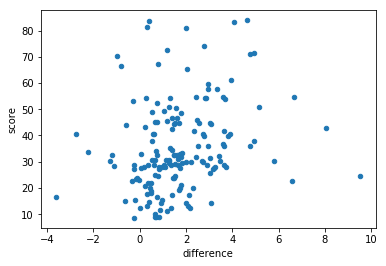

In [109]:
# the linear correlation is quite high when selection "GOV" or "POL" but the plots don't look
# much more appealing
diff_in_out.plot.scatter(x="difference", y="score")
diff_in_out.head()[["difference", "avg_tone_x", "avg_tone_y", "score"]].corr()

#### Analyzing the influence of actor types
plot the outer view for the main actor types as well as a plot comparing the average view (on all countries) for each actor type

In [19]:
ACTOR_TYPES = ["COP", "EDU", "GOV", "JUD", "LEG", "MED", "MNC", "MIL"]
ACTOR_TYPES_DESCRIPTION = {"COP": "Police", "GOV": "Government", "EDU": "Education",
                          "JUD": "Judiciary", "LEG": "Legislature", "MED": "Media",
                           "MNC": "Big Corporations", "MIL": "Military"}
country_outer_type_view = country_outer_type_view[country_outer_type_view.actor_type.apply(
    lambda x: x in ACTOR_TYPES)]

# building list of dfs (one df per actor type + one for all of them) 
dfs = [country_outer_type_view[country_outer_type_view.actor_type == i] for i in ACTOR_TYPES]
dfs.append(country_outer_view)
dfs_names = [ACTOR_TYPES_DESCRIPTION[i] for i in ACTOR_TYPES] + ["all types"]

In [20]:
export_maps_locally(dfs, "avg_tone", dfs_names, 
                      title="Opinion of the rest of the world on a given country", 
                      colorbar_title="average tone", 
                      colorbar_scale=(-7,1),
                      file_name="outer_opinion_by_type.html", export=False)

#### clustering with or without actor_types
The clustering is done only with the biggest 40 countries to remove noise generated by minor countries (both for number of elements and number of dimensions). This is also a way to insure that we won't consider unreliable (only few mentions) columns too much. We use hierarchical clustering to identify the clusters.

In [21]:
def get_clustering_matrix(to_cluster, countries, cluster_on_popularity,
                          country_codes=country_codes):
    """
    returns the matrix used for clustering
    
    :param to_cluster: a df containing the countries to cluster from
    :param countries: list of countries to cluster from
    :param cluster_on_popularity: wether we cluster on the way we are seen by other countries
    or on the way we see other countries
    :param country_codes: the df that contains the mapping from country names to country codes
    """
    to_cluster = to_cluster[["actor_country", "mention_country", "avg_tone"]]
    to_cluster = to_cluster.set_index(["actor_country", "mention_country"])  # so that access is fast
    opinions = np.zeros((countries.shape[0], countries.shape[0]))  # if there are no mentions about
    # that country, the count should be of 0
    for i in range(opinions.shape[0]):
        for j in range(opinions.shape[0]):
            try:
                elem = to_cluster.loc[countries[i], countries[j]]  # the way j talks about i
                opinions[i,j] = elem["avg_tone"] 
            except KeyError as e:
                pass  # in this case we leave the default value in the array since there is no mention
    
    if not cluster_on_popularity:  # in that case categorize a country by the way he talk about others
        opinions = np.transpose(opinions)  
        
    return opinions

In [22]:
def compute_dendogram(selected_type, countries, cluster_on_popularity, save_fig,
                      country_to_country_view=country_to_country_view, 
                      country_to_type_view=country_to_type_view):
    """
    clusters the given data and shows the corresponding dendogram
    
    :param countries: the countries to cluster on
    :param selected_type: the actor type to cluster on or all
    :param cluster_on_popularity: wether we cluster on the way we are seen by other countries
    or on the way we see other countries
    :param save_fig: wether we save teh figure or not
    :param country_to_country_view: the df to use if selected_type is ALL
    :param country_to_type_view: the df to use if selected_type is not ALL
    """
    # only uses mentions where actor_type is selected_type
    title = "Dendogram of the biggest countries " + ("by popularity" if cluster_on_popularity else "by opinion")
    if selected_type == "ALL":
        title += " on all actor types"
        to_cluster = country_to_country_view[country_to_country_view.apply(lambda x: 
                x.actor_country in countries and x.mention_country in countries, axis = 1)].copy()
    else:
        title += f" on {ACTOR_TYPES_DESCRIPTION[selected_type]}"
        to_cluster = country_to_type_view[country_to_type_view.apply(lambda x: x.actor_country 
            in countries and x.mention_country in countries and 
                                            x.actor_type == selected_type , axis = 1)].copy()
    
    countries = np.intersect1d(to_cluster.actor_country.unique(), to_cluster.mention_country.unique())
    opinions = get_clustering_matrix(to_cluster, countries, cluster_on_popularity=cluster_on_popularity)
    model = AgglomerativeClustering(n_clusters=13, affinity="l1", linkage="average")  # uses l1
    # norm because l2 norm is more sensible to big variations than to small ones

    clusters = model.fit_predict(opinions)
    plot_dendrogram(model, title=title, save_fig=save_fig, labels=countries)

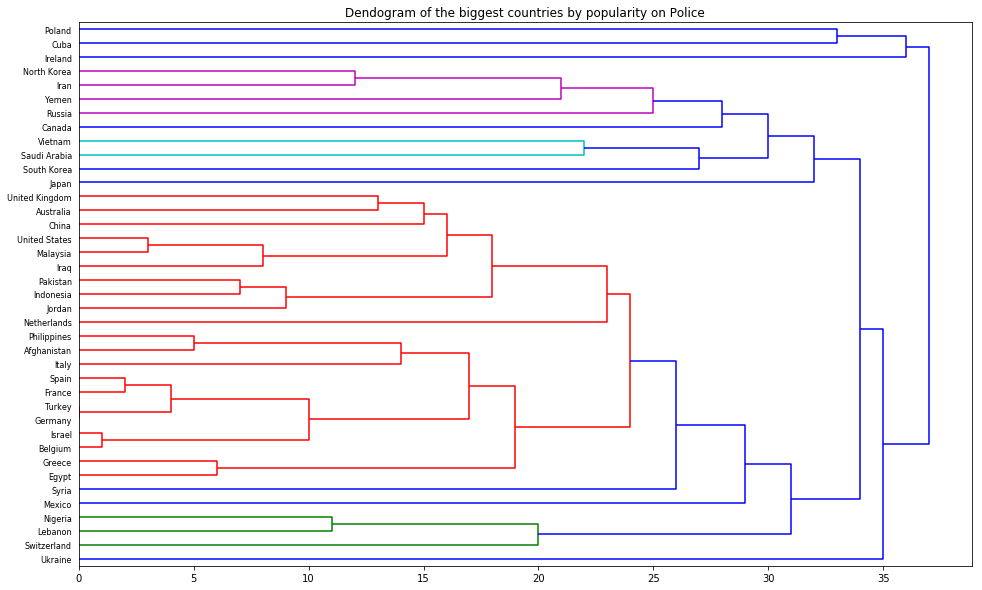

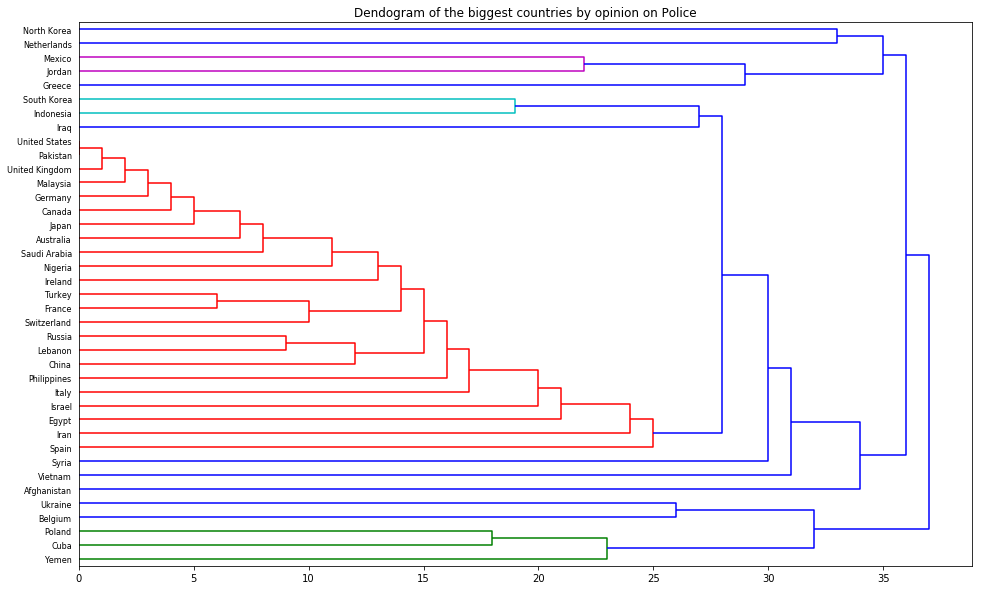

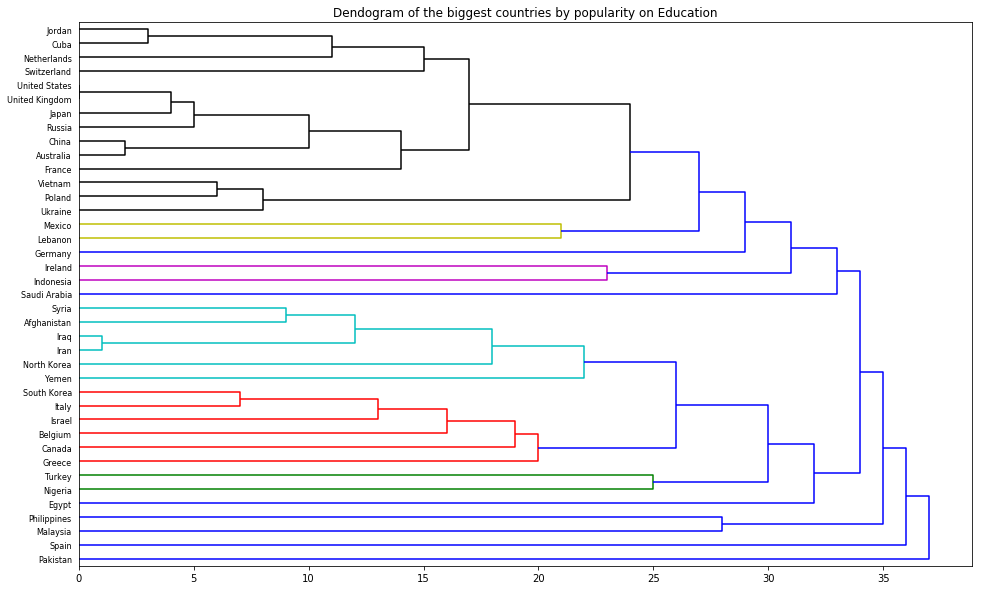

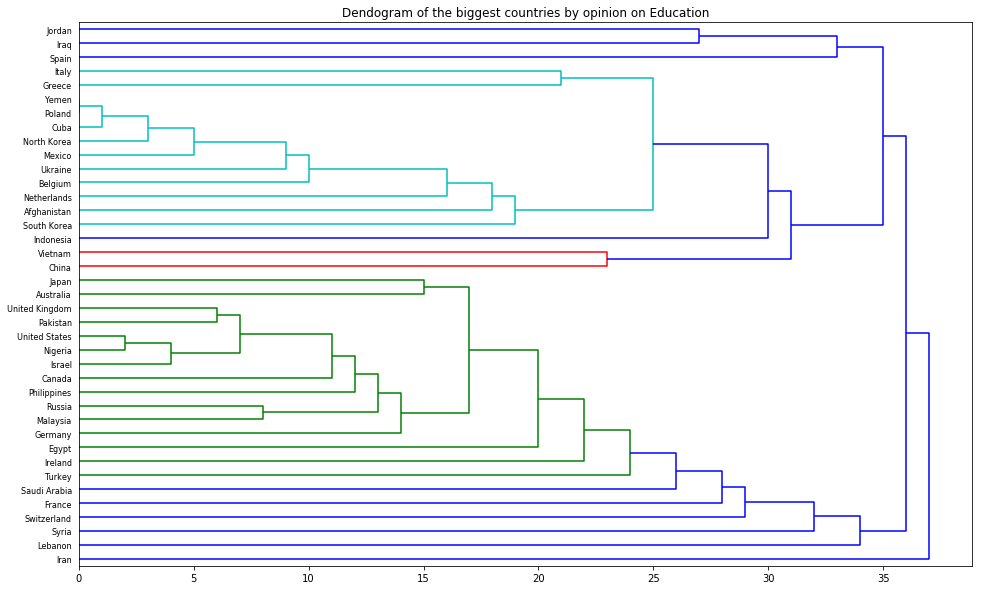

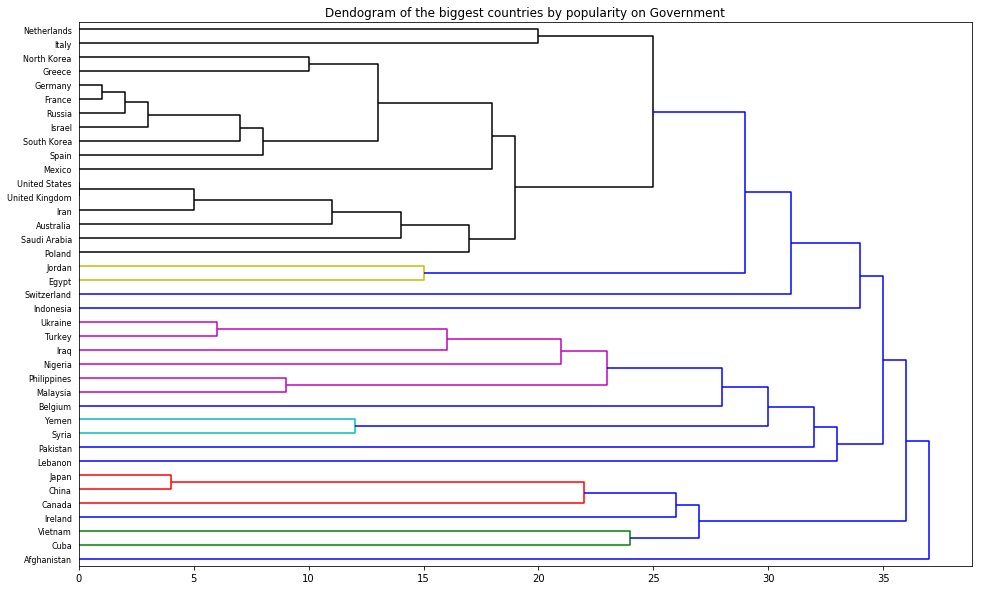

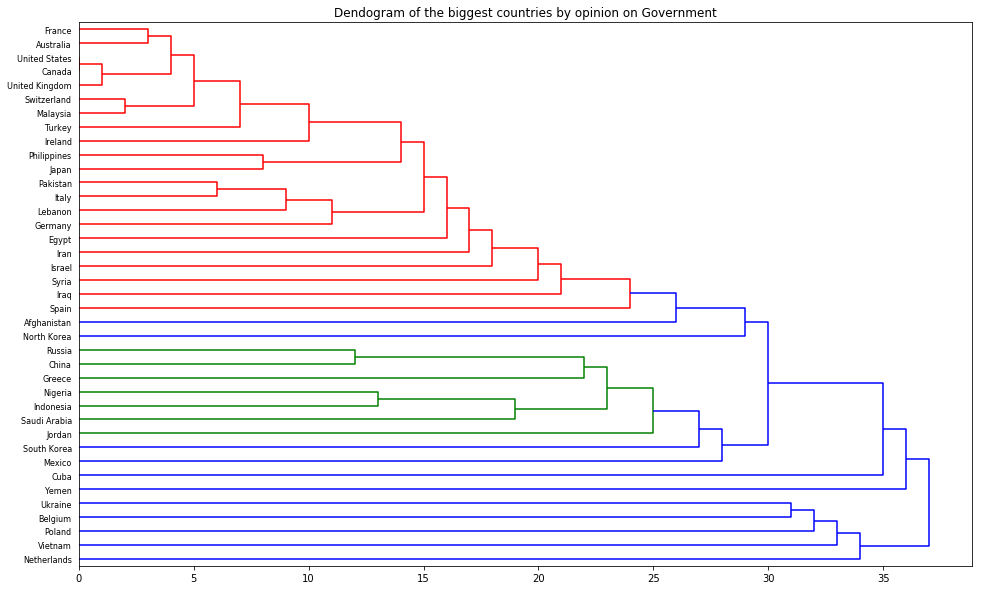

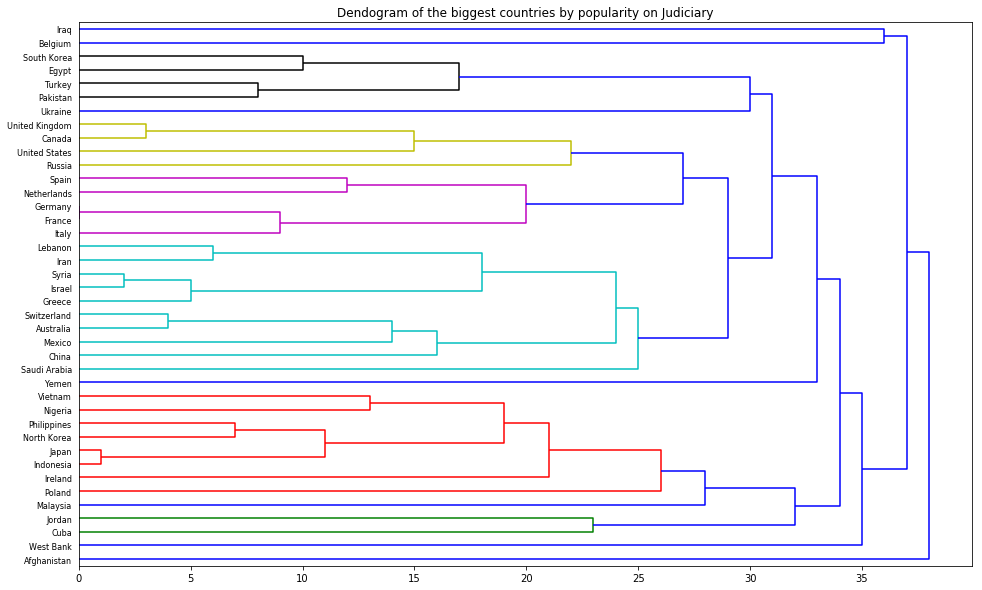

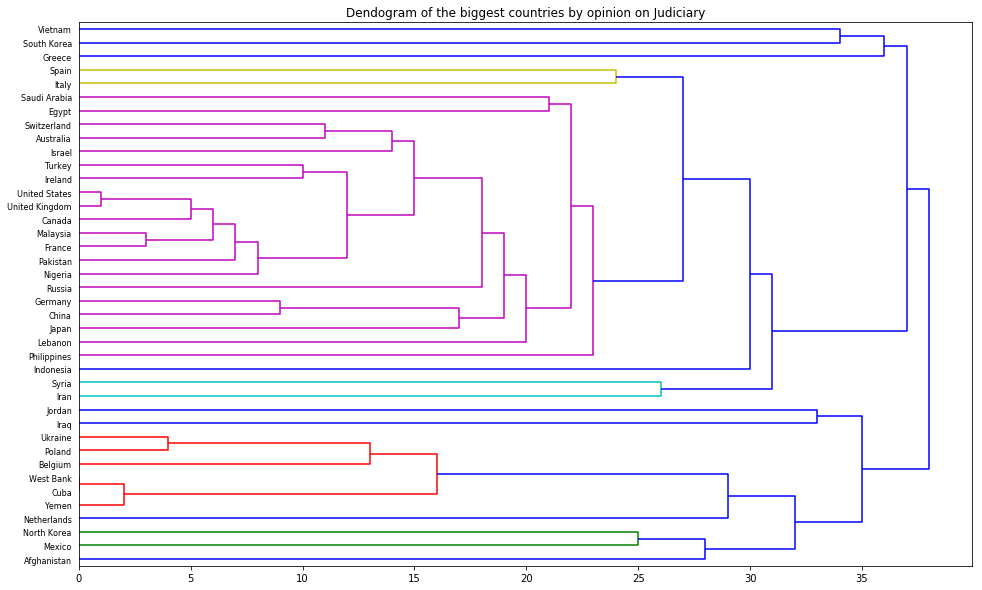

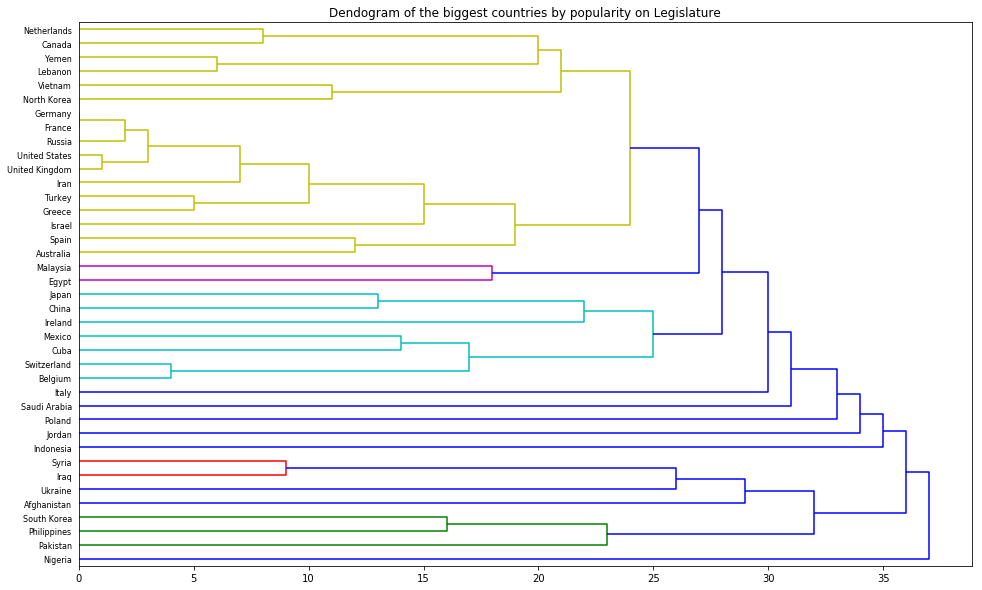

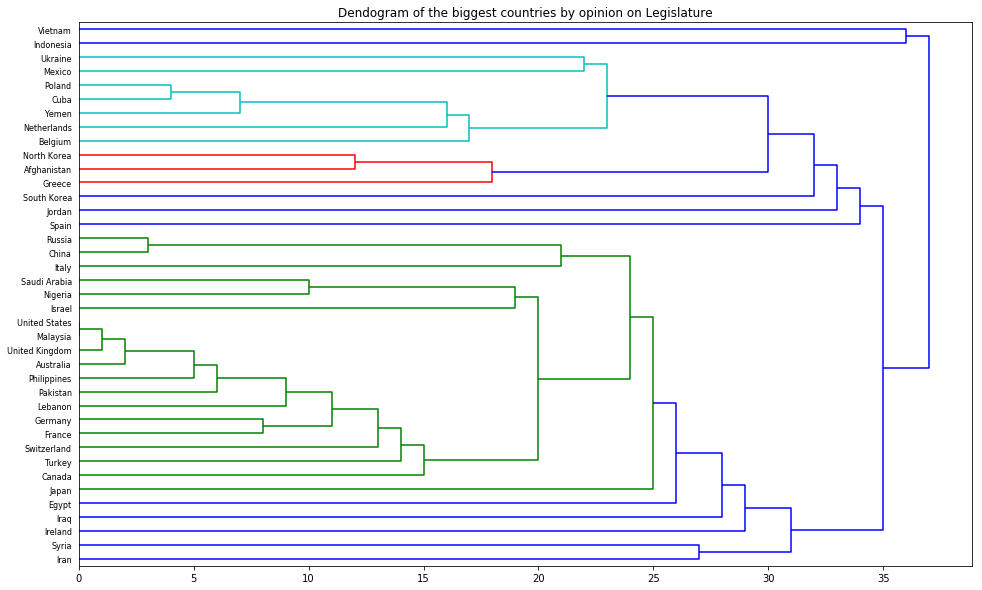

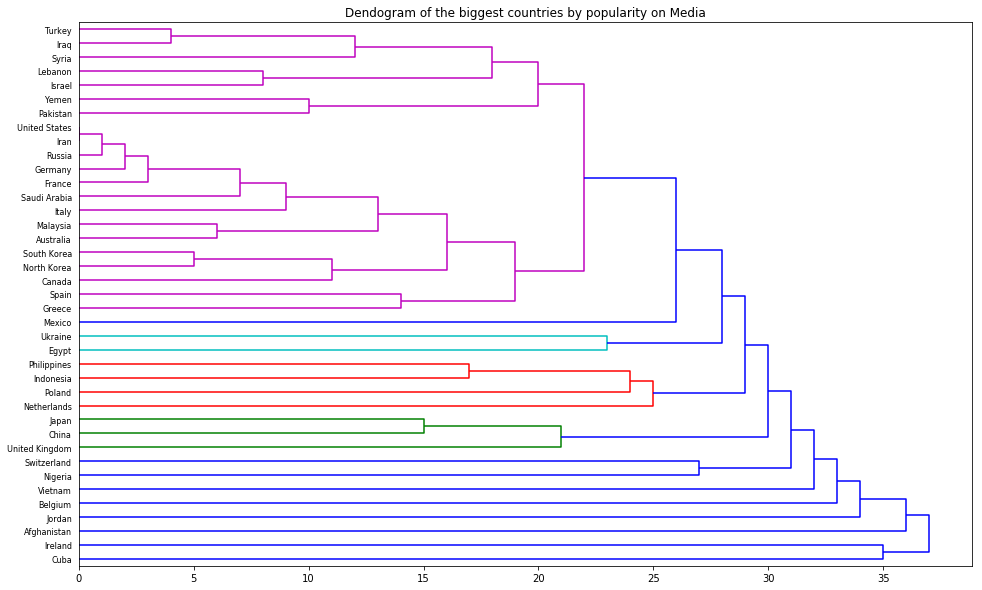

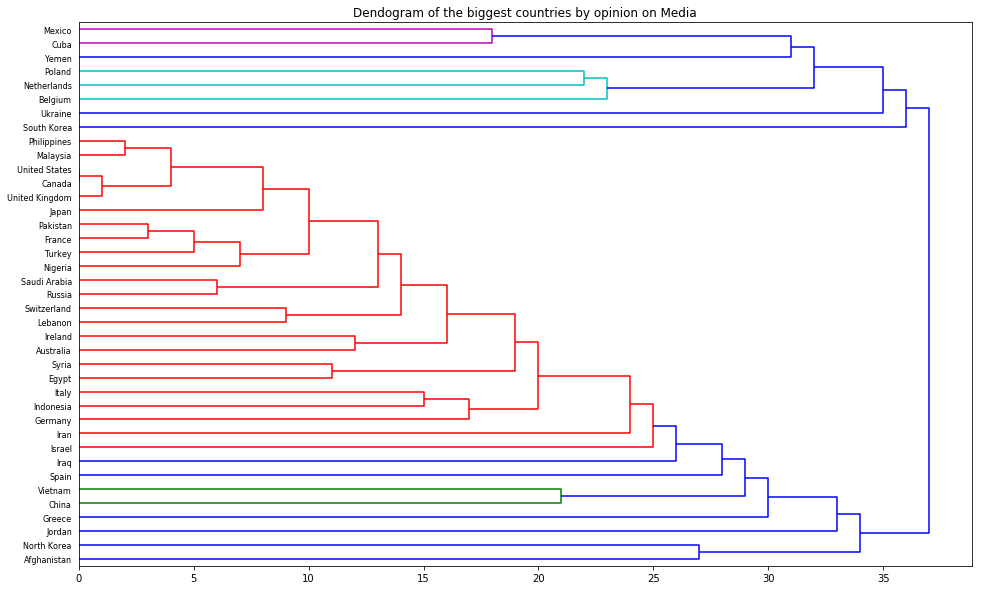

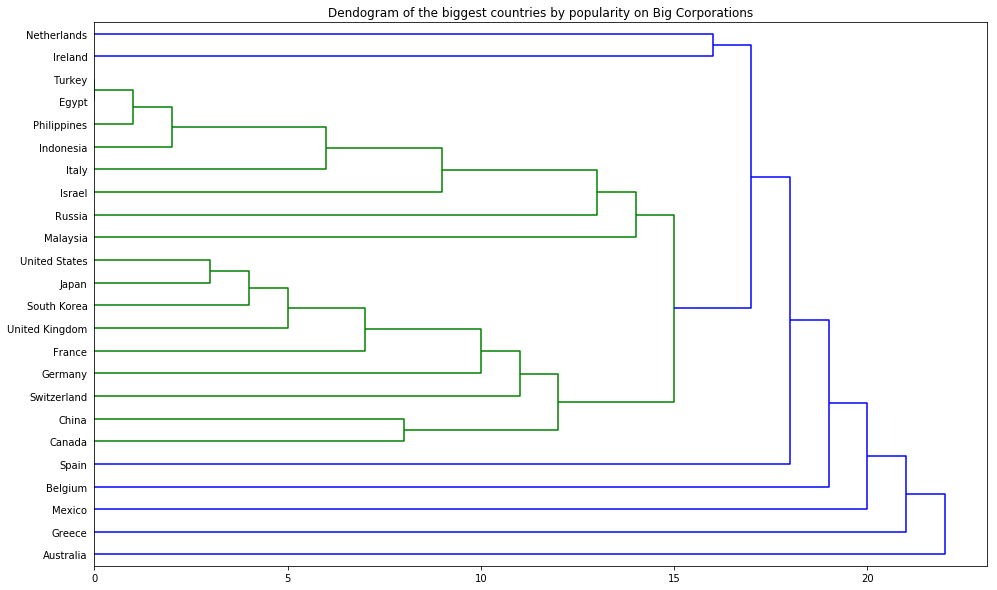

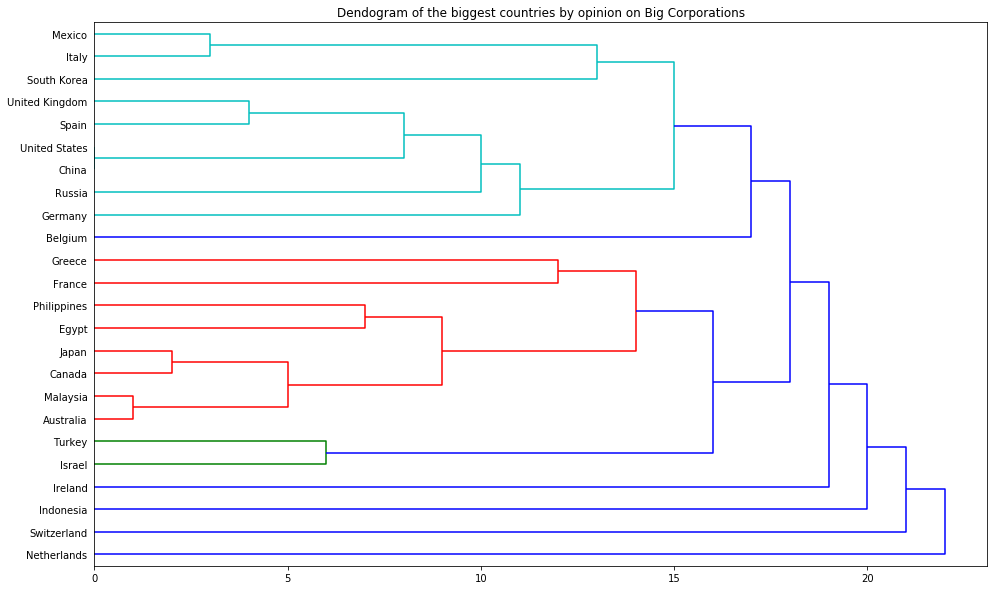

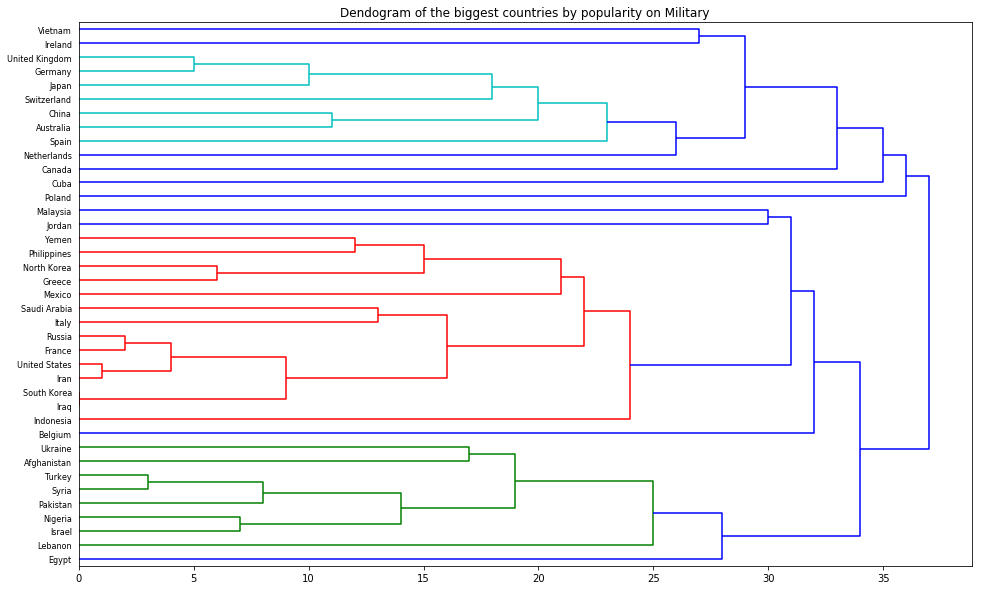

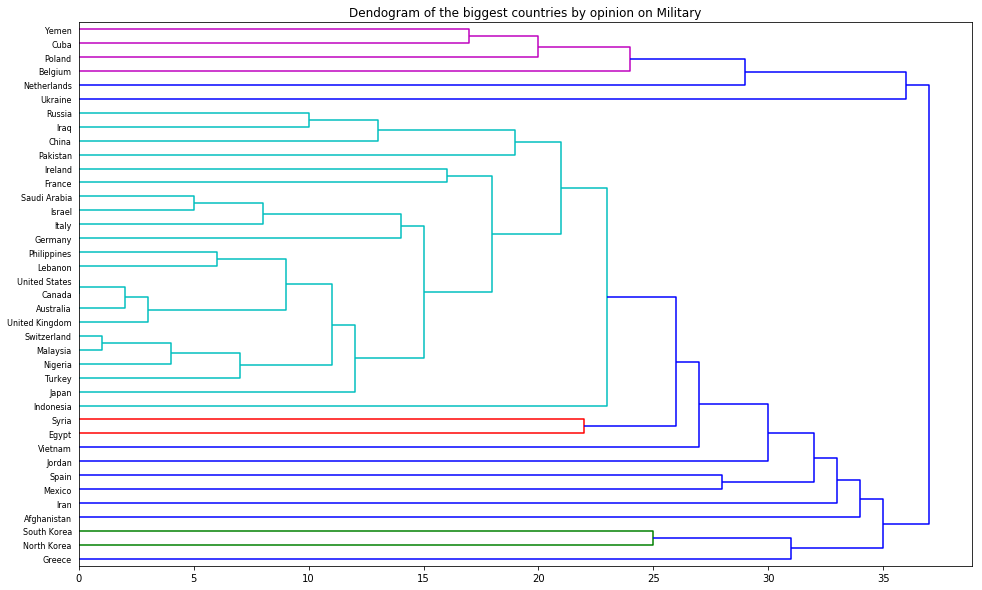

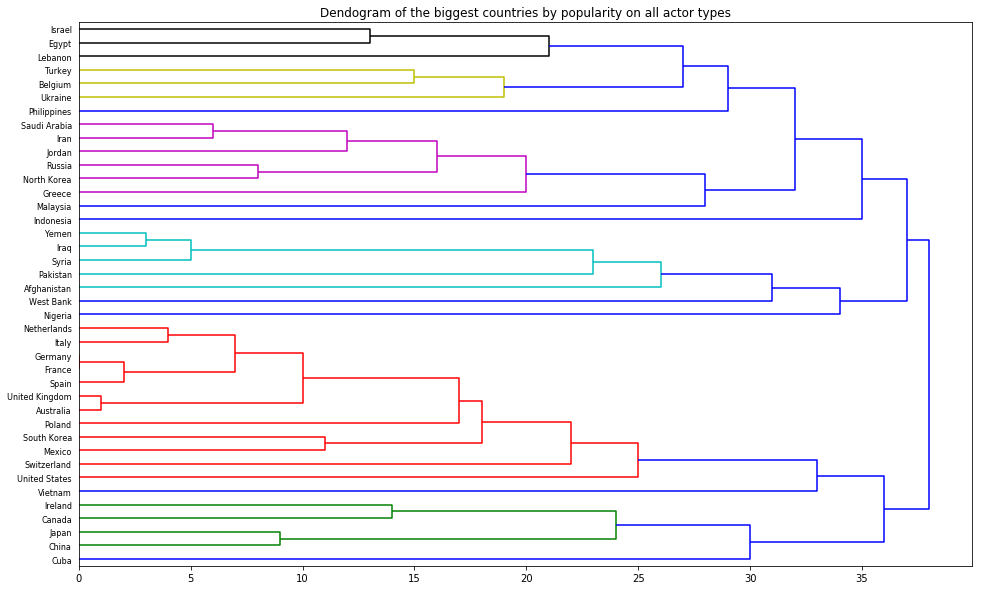

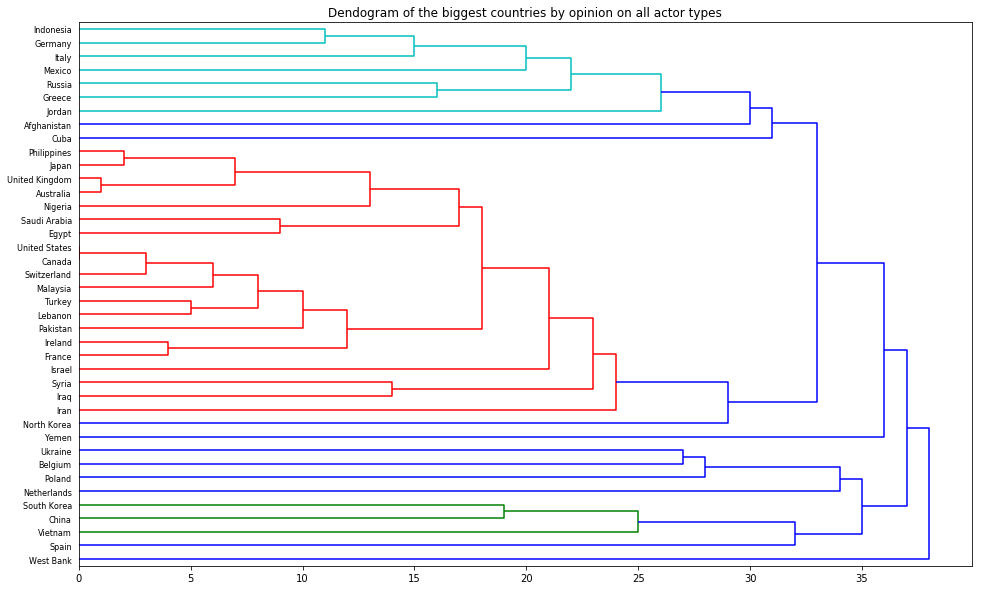

In [120]:
# taking the biggest countries in term of references
countries = list(country_outer_view.sort_values(by="count_mentions", 
                                                    ascending=False).head(40).country)

for i in ACTOR_TYPES + ["ALL"]:
    for j in [True, False]:
        compute_dendogram(i, countries, cluster_on_popularity=j, save_fig=False)

#### Inner media variance
We will sort sources of each country by importance (growing number of news) and group progressively the consecutive sources to form groups that have the same count of mentions but that contains news sources of very different sizes.

In [24]:
def get_source_importance(ser, nbr_clutsers):
    """
    given a serie containing the news sources of a country sorted by number of mentions and
    their number of mentions,
    return a label(0 to nbr_clutsers-1) for each of these sources so that each label contains
    as much mentions and that a smaller label contains smaller sources
    """
    cumsum = ser.cumsum()
    total_nbr_mentions = cumsum.tail(1)
    offsets = np.array([i * total_nbr_mentions/nbr_clutsers for i in range(nbr_clutsers)]).flatten()
    # lower bound for each cluster
    return cumsum.apply(lambda x: np.searchsorted(offsets, x) - 1) # offset in list

In [25]:
def compute_count_mean_std_from_subsets(df):
    """
    compute the count, mean and std on all the rows of the df having that each row contains 
    the count of elements and the std, using the folliwing:
    count_mentions_all = sum count_mentions
    avg_tone_all = avg_tone weighted by num_mentions
    std_tone_all = sqrt(1/(n-1) (sum_{i in subsets} (n_i-1)*std_i^2 + n_i*(mean_i - mean_all)^2 )
    n-1 because stddev is the unbiased variance estimator
    
    :param df: the dataframe
    """
    output = df[["count_mentions", "avg_tone", "std_tone"]].sum()
    output["avg_tone"] = (df["count_mentions"] * df["avg_tone"]).sum() / output["count_mentions"]
    if output["count_mentions"] == 1:
        output["std_tone"] = 0
    else:
        output["std_tone"] = (((df["count_mentions"] - 1) * df["std_tone"]**2 + \
                        df["count_mentions"] * (df["avg_tone"] - output["avg_tone"])**2).sum() \
                             / (output["count_mentions"] - 1))**0.5
    return output  

In [26]:
NBR_CLUSTERS = 3

if NBR_CLUSTERS == 2:
    frame_names = ["small medias", "big medias"]
elif NBR_CLUSTERS == 3:
    frame_names = ["small medias", "medium medias", "big medias"]
else:
    frame_names = [f"cluster {i}" for i in range(NBR_CLUSTERS)] 

# classifying te news into different clusters
source_cluster = media_to_country_view.groupby(["source_country",
                                            "source_name"]).agg({"count_mentions": "sum"})
source_cluster = source_cluster.sort_values(["source_country", "count_mentions"])
source_cluster["cluster"] = source_cluster.groupby("source_country").count_mentions.apply(
    lambda x: get_source_importance(x, NBR_CLUSTERS))
source_cluster = source_cluster.reset_index()

# computing the count of mentions, mean and std for each triple (source country, actor country,
# source_size)
news_to_country = media_to_country_view.merge(
    source_cluster[["source_country", "source_name", "cluster"]], 
    left_on=["source_name", "source_country"], right_on=["source_name", "source_country"],
    suffixes=('',''))
news_to_country = news_to_country.groupby(["actor_country", "source_country", 
            "cluster"]).apply(lambda x: compute_count_mean_std_from_subsets(x)).reset_index()

In [27]:
# computing the inner view from the country to country view
inner_cluster = (news_to_country[news_to_country.apply(lambda x: x.actor_country ==
        x.source_country, axis=1)])[["actor_country", "cluster", "avg_tone",
                                     "std_tone", "count_mentions"]]
inner_cluster.rename(columns={"actor_country": "country"}, inplace=True)

# do not show countries that do not have the min consider in all the clusters
inner_cluster = inner_cluster.groupby("country").filter(lambda x: x.count_mentions.min()\
        > MIN_CONSIDER and x.count_mentions.count() == NBR_CLUSTERS)
inner_all_clusters = country_inner_view[country_inner_view.country.isin(inner_cluster.country)]

add_CI_to_DF(inner_cluster)

# list of inner cluster for each cluster
inner_clusters = [inner_cluster[inner_cluster.cluster == i] for i in range(NBR_CLUSTERS)]

export_maps_locally(inner_clusters + [inner_all_clusters], "avg_tone", frame_names + ["all medias"], 
                    title="inner opinion for different size of medias", 
                    colorbar_title="average tone",
                    colorbar_scale=(-5,2),
                    file_name="media_inner.html", export=False)

In [28]:
# computing the outer view from the country to country view
outer_cluster = (news_to_country[news_to_country.apply(lambda x: x.actor_country !=
        x.source_country, axis=1)])[["actor_country", "cluster", "avg_tone",
                                     "std_tone", "count_mentions"]]
outer_cluster = outer_cluster.groupby(["actor_country", "cluster"]).apply(
    lambda x: compute_count_mean_std_from_subsets(x)).reset_index()

outer_cluster.rename(columns={"actor_country": "country"}, inplace=True)

# do not show countries that do not have the min consider in all the clusters
outer_cluster = outer_cluster.groupby("country").filter(lambda x: x.count_mentions.min()\
        > MIN_CONSIDER and x.count_mentions.count() == NBR_CLUSTERS)
outer_all_clusters = country_outer_view[country_outer_view.country.isin(outer_cluster.country)]

add_CI_to_DF(outer_cluster)

# list of outer cluster for each cluster
outer_clusters = [outer_cluster[outer_cluster.cluster == i] for i in range(NBR_CLUSTERS)]


export_maps_locally(outer_clusters + [outer_all_clusters], "avg_tone", frame_names + ["all medias"], 
                    title="outer opinion for different size of medias", 
                    colorbar_title="average tone",
                    colorbar_scale=(-7,1),
                    file_name="media_outer.html", export=False)

In [29]:
source_cluster[source_cluster.source_country == "Belgium"].sort_values(
    by="count_mentions", ascending=False).reset_index()

,index,source_country,source_name,count_mentions,cluster
0,966,Belgium,paneuropeannetworks.com,9368,2
1,965,Belgium,brusselstimes.com,6328,2
2,964,Belgium,deredactie.be,5480,1
3,963,Belgium,ec.europa.eu,4695,1
4,962,Belgium,investineu.com,3164,1
5,961,Belgium,epc.eu,2970,1
6,960,Belgium,eubulletin.com,2848,0
7,959,Belgium,eeas.europa.eu,2667,0
8,958,Belgium,freesun.be,1459,0
9,957,Belgium,camer.be,1201,0


In [119]:
source_cluster.head()

,source_country,source_name,count_mentions,cluster
0,Afghanistan,blogcindario.com,1,0
1,Afghanistan,lavieoverseas.com,21,0
2,Afghanistan,fatbidin.com,106,0
3,Afghanistan,mail.gov.af,217,0
4,Afghanistan,bokhdinews.af,220,0
